# JAX Quickstart

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/notebooks/quickstart.ipynb)

**JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation for high-performance machine learning research.**

With its updated version of [Autograd](https://github.com/hips/autograd), JAX
can automatically differentiate native Python and NumPy code. It can
differentiate through a large subset of Python’s features, including loops, ifs,
recursion, and closures, and it can even take derivatives of derivatives of
derivatives. It supports reverse-mode as well as forward-mode differentiation, and the two can be composed arbitrarily
to any order.

What’s new is that JAX uses
[XLA](https://www.tensorflow.org/xla)
to compile and run your NumPy code on accelerators, like GPUs and TPUs.
Compilation happens under the hood by default, with library calls getting
just-in-time compiled and executed. But JAX even lets you just-in-time compile
your own Python functions into XLA-optimized kernels using a one-function API.
Compilation and automatic differentiation can be composed arbitrarily, so you
can express sophisticated algorithms and get maximal performance without having
to leave Python.

In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

In [3]:
def sum_logistic(x):
  return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))

[0.25       0.19661197 0.10499357]


Let's verify with finite differences that our result is correct.

In [4]:
def first_finite_differences(f, x):
  eps = 1e-3
  return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in jnp.eye(len(x))])


print(first_finite_differences(sum_logistic, x_small))

[0.24998187 0.1965761  0.10502338]


Taking derivatives is as easy as calling {func}`~jax.grad`. {func}`~jax.grad` and {func}`~jax.jit` compose and can be mixed arbitrarily. In the above example we jitted `sum_logistic` and then took its derivative. We can go further:

In [5]:
print(grad(jit(grad(jit(grad(sum_logistic)))))(1.0))

-0.035325598


For more advanced autodiff, you can use {func}`jax.vjp` for reverse-mode vector-Jacobian products and {func}`jax.jvp` for forward-mode Jacobian-vector products. The two can be composed arbitrarily with one another, and with other JAX transformations. Here's one way to compose them to make a function that efficiently computes full Hessian matrices:

In [6]:
from jax import jacfwd, jacrev
def hessian(fun):
  return jit(jacfwd(jacrev(fun)))

Second tests. This is closer to what we do in machine learning.

In [7]:
key = random.PRNGKey(0)

In [8]:
def sigmoid(x):
    return 0.5 * (jnp.tanh(x / 2) + 1)

# Outputs probability of a label being true.
def predict(W, b, inputs):
    return sigmoid(jnp.dot(inputs, W) + b)

# Build a toy dataset.
inputs = jnp.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = jnp.array([True, True, False, True])

# Training loss is the negative log-likelihood of the training examples.
def loss(W, b):
    preds = predict(W, b, inputs)
    label_probs = preds * targets + (1 - preds) * (1 - targets)
    return -jnp.sum(jnp.log(label_probs))

# Initialize random model coefficients
key, W_key, b_key = random.split(key, 3)
W = random.normal(W_key, (3,))
b = random.normal(b_key, ())

In [9]:
# Differentiate `loss` with respect to the first positional argument:
W_grad = grad(loss, argnums=0)(W, b)
print('W_grad', W_grad)

# Since argnums=0 is the default, this does the same thing:
W_grad = grad(loss)(W, b)
print('W_grad', W_grad)

# But we can choose different values too, and drop the keyword:
b_grad = grad(loss, 1)(W, b)
print('b_grad', b_grad)

# Including tuple values
W_grad, b_grad = grad(loss, (0, 1))(W, b)
print('W_grad', W_grad)
print('b_grad', b_grad)

W_grad [-0.16965583 -0.8774644  -1.4901346 ]
W_grad [-0.16965583 -0.8774644  -1.4901346 ]
b_grad -0.29227245
W_grad [-0.16965583 -0.8774644  -1.4901346 ]
b_grad -0.29227245


Test 3. This is directly an example with a tensor network.

In [10]:
import quimb.tensor as qtn
import numpy as np
from tqdm.auto import tqdm
import itertools
%config InlineBackend.figure_format = "svg"
from matplotlib import pyplot as plt
from functools import reduce

In [11]:
n = 8
chi = 8

In [12]:
psi_ref = qtn.MPS_rand_state(n, bond_dim=chi, normalize=True, tags=["ref"])
psi_ref.compress()
psi_ref

<MatrixProductState(tensors=8, indices=15, L=8, max_bond=8)>

In [13]:
psi_orig = qtn.MPS_rand_state(n, bond_dim=chi, normalize=True, tags=["approx"])
psi_orig.compress()
psi_orig

<MatrixProductState(tensors=8, indices=15, L=8, max_bond=8)>

In [14]:
fidelity = psi_ref.H & psi_orig ^ all
if fidelity < 0:
	psi_orig *= -1
	fidelity *= -1
fidelity

0.04800855901784419

In [15]:
def loss(f: float, norm: float) -> float:
	return (abs(f) - 1) ** 2  + (norm - 1) ** 2

100%|██████████| 100/100 [00:05<00:00, 17.87it/s, fidelity=0.945, norm=1.02]


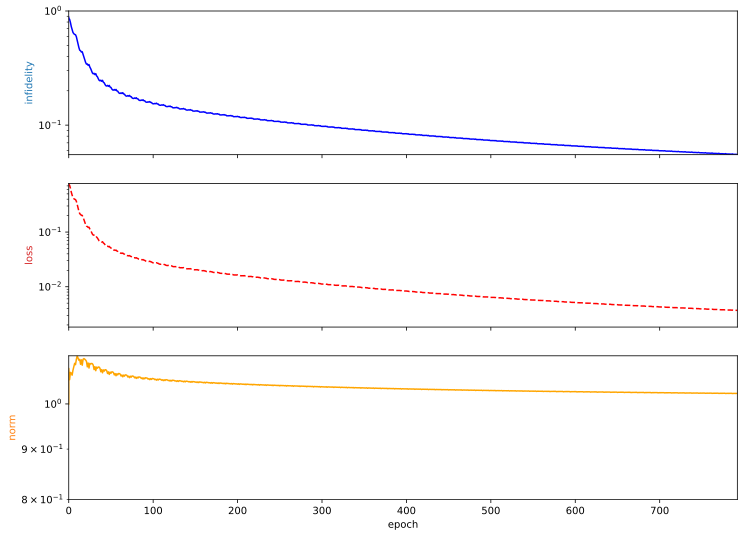

In [ ]:
max_it = 100
alpha = 1
lambd = 0.4

psi = psi_orig.copy(deep=True)
fidelity = psi_ref.H & psi ^ all
norm = psi.norm()

fig = plt.figure(figsize=(12,9))
[ax1, ax2, ax3] = fig.subplots(3,1, sharex=True)
ax3.set_xlabel("epoch")

ax1.set_ylabel("infidelity", color="tab:blue")
ax1.set_ylim(0, 1)
plot1, = ax1.semilogy([0], 1-fidelity, color="blue")

ax2.set_ylabel("loss", color="tab:red")
ax2.set_ylim(0, 1)
plot2, = ax2.semilogy([0], loss(fidelity, norm), color="red", linestyle="dashed")

ax3.set_ylabel("norm", color="tab:orange")
ax3.set_ylim(0, 2)
plot3, = ax3.semilogy([0], norm, color="orange")

with tqdm(range(max_it)) as progressbar:
	progressbar.set_postfix(fidelity=f"{fidelity}")

	for it in progressbar:
		sweeps = itertools.chain(psi.site_tags)
		for sweep_it, site_tag in enumerate(sweeps):
			# compute gradient of norm
			[psiH, psi] = qtn.tensor_network_align(psi.H, psi)
			psiH.drop_tags(["approx"])

			norm_tn = (psiH | psi)
			norm_tn.delete([site_tag, "approx"])
			diff_norm = norm_tn ^ all
			
			# pop site tensor
			[orig] = psi.select_tensors([site_tag]) # NOTE = norm_tn.select_tensors([site_tag, "approx"])
			psi.delete([site_tag])

			# compute gradient
			grad_fidelity = (psi_ref.H & psi) ^ all
			grad_norm = diff_norm + diff_norm.conj()
			grad = 2 * (fidelity - 1) * grad_fidelity + 2 * (norm - 1) * grad_norm
			tensor = orig - lambd * grad
			# tensor.normalize(inplace=True)

			# link new tensor to psi
			tensor.drop_tags()
			for tag in [site_tag, "approx"]:
				tensor.add_tag(tag)

			psi.add_tensor(tensor)

			# renormalize psi
			# psi.normalize()

			# recompute fidelity, norm
			fidelity = abs(psi_ref.H & psi ^ all)
			norm = psi.norm()

			# update plot
			plot1.set_xdata(np.append(plot1.get_xdata(), psi.nsites * it + sweep_it))
			plot1.set_ydata(np.append(plot1.get_ydata(), 1-fidelity))
			plot2.set_xdata(np.append(plot2.get_xdata(), psi.nsites * it + sweep_it))
			plot2.set_ydata(np.append(plot2.get_ydata(), loss(fidelity, norm)))
			plot3.set_xdata(np.append(plot3.get_xdata(), psi.nsites * it + sweep_it))
			plot3.set_ydata(np.append(plot3.get_ydata(), norm))

		progressbar.set_postfix(fidelity=fidelity, norm=norm)

ax1.set_xlim(0, it * psi.nsites)
ax1.set_ylim(min(plot1.get_ydata()), 1)
ax2.set_ylim(min(plot2.get_ydata()) / 2, max(plot2.get_ydata()))
ax3.set_ylim(0.8, max(plot3.get_ydata()))

plt.show()